In [19]:
import cvxpy as cvx
import numpy as np
import matplotlib.pylab as py
from matplotlib import pyplot as plt
from scipy import linalg
%matplotlib inline

In [58]:
from sklearn.covariance import GraphLasso as GL

In [20]:
def estimatePhi(S, rho):
    """
        S is the empirical covariance matrix.
    """
    assert S.shape[0] == S.shape[1], "Matrix must be square"
    n = S.shape[0]
    
    Phi = cvx.Variable(n, n)
    
    obj = cvx.Minimize(-(cvx.log_det(Phi) - cvx.trace(S*Phi) - rho*cvx.norm(Phi,1)))
    constraints = []

    prob = cvx.Problem(obj,constraints)
    prob.solve(solver=cvx.SCS, eps=1e-5)
    return Phi.value

In [30]:
def GroupGraphicLasso(S, rho, groups):
    """
        S is the empirical covariance matrix.
    """
    assert S.shape[0] == S.shape[1], "Matrix must be square"
    n = S.shape[0]
    
    Phi = cvx.Variable(n, n)
    
    group_pennal=[]
    for group in groups:
        group_pennal.append(cvx.norm(Phi[group,group],"fro"))
    obj = cvx.Minimize(-(cvx.log_det(Phi) - cvx.trace(S*Phi) - rho*sum(group_pennal)))
    constraints = []

    prob = cvx.Problem(obj,constraints)
    prob.solve(solver=cvx.SCS, eps=1e-5)
    return Phi.value

In [78]:
def set_zero(data):
    '''to visualize clearly, we set all diagonal element to 0'''
    z=np.zeros(data.shape)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if i!=j:
                z[i,j]=data[i,j]
    return z
def add_group(data,group):
    '''add group to toy data'''
    for i in group:
        for j in group:
            if i==j:
                pass
            else:
                data[i,j] += 0.25
def createToyData(ranNum=20,
                  size=(100,20),
                 groups=[np.array([0,1,2,3,4,5]),np.array([0,1,2]),np.array([3,4,5]),np.array([6,7,8,9])]
                 ):
    '''creat toy test data , parameter:
            ranNum: random state
            size: (num1,num2) num1 mean examples, num2 means features.
            groups: we require groups in a list, each element is a numpy.array() object example:[np.array([0,1,2,3,4,5])]
        this function return :
            X: toy data X
            prec: ground truth precision matrix
    '''
    n_samples = size[0]
    n_features = size[1]
    ##random state
    prng = np.random.RandomState(ranNum)
    prec = np.zeros(shape=(n_features,n_features))
    for i in range(n_features):
        prec[i,i]+=1.

    #groups=[np.array([0,1,2,3,4,5]),np.array([0,1,2]),np.array([3,4,5]),np.array([6,7,8,9]),np.array([6,7]),np.array([8,9])]
    for g in groups:
        add_group(prec,g)
    cov = linalg.inv(prec)
    ##using random state to create X
    X = prng.multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    X -= X.mean(axis=0)
    X /= X.std(axis=0)
    return X,prec
groups=[np.array([0,1,2,3,4,5]),np.array([0,1,2]),np.array([3,4,5]),np.array([6,7,8,9]),np.array([6,7]),np.array([8,9]),
       np.array([10,11,12,13,14,15]),np.array([10,11,12]),np.array([13,14,15]),np.array([16,17,18,19]),np.array([16,17]),
        np.array([18,19]),np.array([6,7,8,9,10,11,12,13,14,15])]
groups1=[np.array([0,1]),np.array([1,4]),np.array([4,5]),np.array([4,7])]
X,prec=createToyData(groups=groups)

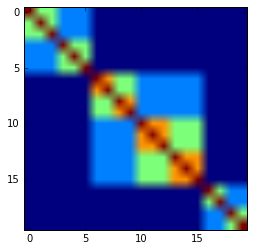

In [79]:
plt.imshow(prec)
plt.show()

In [98]:
pennal_list=np.arange(0.001,0.2,0.03)
print pennal_list

[ 0.001  0.031  0.061  0.091  0.121  0.151  0.181]


In [99]:
ggl_list=[]
gl_list=[]
for pennal in pennal_list:
    ###grouped graphic lasso
    S=np.cov(X.T)
    print S.shape
    test=GroupGraphicLasso(S,pennal,groups)
    ggl_list.append(test)
    ###graphic lasso
    model = GL(alpha=pennal * 0.5)
    model.fit(X)
    #cov_ = model.covariance_
    prec_ = model.precision_
    gl_list.append(prec_)

(20L, 20L)
(20L, 20L)
(20L, 20L)
(20L, 20L)
(20L, 20L)
(20L, 20L)
(20L, 20L)


In [100]:
print len(ggl_list)
for i in ggl_list:
    print i.shape

7
(20L, 20L)
(20L, 20L)
(20L, 20L)
(20L, 20L)
(20L, 20L)
(20L, 20L)
(20L, 20L)


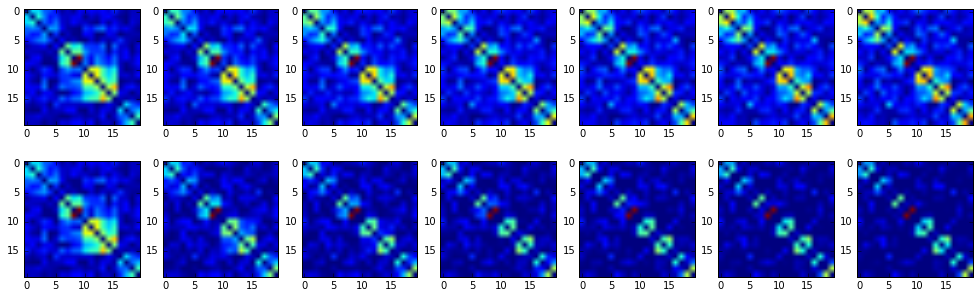

In [101]:
pennelty_number=len(ggl_list)
fig,ax = plt.subplots(ncols=pennelty_number,nrows=2)
for i in range(2):
    for j in range(pennelty_number):
            if i<1:
                value=set_zero(abs(ggl_list[j]))
                ax[i][j].imshow(value)
            else:
                value=set_zero(abs(gl_list[j]))
                ax[i][j].imshow(value)
fig.set_size_inches(17,5)
plt.show()